<div style="direction:rtl">
<div>
<center>
<p style="font-size:30px; color:blue">
<strong>
به نام خدا
<br>
محمدمهدی جراحی، نگین جعفری، محمدامین قاسم‌زاده
<br>
تمرین پنجم درس بازیابی پیشرفته‌ی اطلاعات
</strong>
</p>
</center>
</div>
</div>

<div style="direction:rtl">
<div style="color:black;">
<center>
<p style="font-size:30px;color:blue;">
<strong>
توضیحات کلی راجع به تمرین
</strong>
</p>
</center>
در این تمرین، قصد داریم الگوریتم‌های تحلیل لینک را برای داده‌های قرانی اجرا کنیم.
<br>
سناریوی مورد نظر ما، سناریوی پیشنهادی اول است.
<br>
این سناریو به شرح زیر است:«هر آیه در حکم یک گره در نظر گرفته شده و در صورتی که دو ایه به هم شبیه بوده به یکدیگر متصل شوند. سپس با الگوریتم تحلیل لینک محوری‌ترین ایه‌ها را بیابید.»
<br>
نکات مهم: برای امبدینگ کلمات در این تمرین از fasttext استفاده کرده‌ایم، مدل مربوط به این تمرین همان مدل تمرین سوم است که از لینک زیر می‌توانید آن را دانلود کنید و در درون پوشه‌ی fasttext_model قرار دهید.
https://drive.google.com/file/d/1yUYer7JXXSIkkleE3cEQlklEAdvo3aeo/view?usp=sharing
<br>
نکته‌ی انتهایی آنکه گزارش کتبی که در صورت سوال خواسته شده بود، در همین نوتبوک به صورت بخش بخش بعد از هر cellنوشته شده که به فهم آسان‌تر کمک می‌کند.
</div>
</div>

In [ ]:
# !pip install camel-tools==1.4.1
# !pip install fasttext

import matplotlib.pyplot as plt
import pandas as pd
from preprocess_quran_text import merged_quran_vec_df_nrmlz, quran_series
from fasttext_vectorizer import sent_to_vec
import networkx as nx
import numpy as np
from sklearn.preprocessing import normalize
import warnings
import tqdm

warnings.filterwarnings("ignore")

<div dir="rtl">
خواندن نام سوره‌های قران و شماره‌ی آن‌ها از فایل
<div>

In [ ]:
verse_names = pd.read_csv('data/verse_names.csv')
verse_names.set_index(verse_names['ردیف'], inplace=True)
verse_names

<div dir="rtl">
محاسبه‌ی بردار امبدینگ برای آیات قرآن
<div>

In [ ]:
merged_corpus_embeddings = merged_quran_vec_df_nrmlz.applymap(sent_to_vec)


<div dir="rtl">
اضافه کردن ستون شماره‌ی سوره به دیتافریم
<div>

In [ ]:
X = merged_corpus_embeddings[['original_normalized']]
X['شماره سوره'] = X.index.to_series().str.split('##').apply(lambda x: int(x[0]))
X

<div dir="rtl">
جدا کردن دیتافریم هر سوره و لیست کردن آن‌ها پشت سرهم
<div>

In [ ]:
list_of_verse_embeddings = [x for _, x in X.groupby(['شماره سوره'])]
list_of_verse_embeddings

<div dir="rtl">
نمایش گراف ساخته شده از روی ماتریس مجاورت وزنی، یال با بیشترین وزن به رنگ مشکی و سایر یال‌ها قرمز هستند. شماره‌ی نود‌ها نیز شماره‌ی آیه در سوره است.
<div>

In [ ]:
def plot_graph(G):
    max_d = np.max([d["weight"] for (u, v, d) in G.edges(data=True)])
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == max_d]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] != max_d]

    pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=5)
    nx.draw_networkx_edges(
        G, pos, edgelist=esmall, width=3, alpha=0.5, edge_color="r", style="dashed"
    )

    # node labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

<div dir="rtl">
تابع find_pivot_aye دو پارامتر می‌گیرد. پارامتر verse_name نام سوره‌ای ست که می‌خواهیم برای آن ایه‌ی محوری را پیدا کنیم. همچنین draw_graph نیز مشخص می‌کند که شکل گراف رسم شود یا نه.
<br>
نکته: اگر خواستید نام سوره‌ای را سرچ کنید، حتما نامی از آن را سرچ کنید که در فایل verse_names موجود است.
در این تابع ابتدا امبدینگ‌های آیه‌های مربوط به سوره‌ی مورد نظر را پیدا می‌کنیم.
<br>
برای آنکه بتوانیم میزان شباهت آیه‌های آن سوره را با هم بسنجیم، ماتریس امبدینگ‌ها را در ترانهاده‌ی خودش ضرب می‌کنیم.   امبدینگ‌ها نرمال یکه شده‌بودند و با ضرب داخلی آن‌ها کسینوس زاویه‌ی بینشان را محاسبه کردیم.
<br>
خروجی که ماتریس P است، دارای قطر اصلی برابر یک است و متقارن نیز هست. در این کاربرد، اینکه یک آیه شبیه خودش باشد، برای ما مهم نیست، لذا قطر اصلی این ماتریس را صفر می‌کنیم.  پس از آن ماتریس را نرمالایز می‌کنیم. دقت کنید که ماتریس P_norm دیگر الزاما متقارن نیست. چرا که این نرمالایز کردن به طریقی صورت می‌گیرد، که جمع هر سطر ماتریس برابر یک شود.
<br>
باتوجه به این اکنون گرافی که از روی ماتریس مجاورت ساخته شود، جهت دار است.
<br>
به این ترتیب با استفاده از الگوریتم page rank و hits آیه‌های محوری را می‌یابیم.
<div>

In [ ]:
def find_pivot_aye(verse_name, draw_graph=False):
    verse_number = verse_names.loc[verse_names['نام سوره'] == verse_name]['ردیف'].tolist()[0]
    df = list_of_verse_embeddings[verse_number - 1]
    verse_matrix = np.array(df['original_normalized'].values.tolist())

    P = verse_matrix.dot(verse_matrix.T)
    np.fill_diagonal(P, 0)
    P_norm = normalize(P, norm='l1')
    G = nx.from_numpy_matrix(P_norm, create_using=nx.MultiDiGraph())
    pr = nx.pagerank(G, alpha=0.9)
    h, a = nx.hits(G)

    if draw_graph:
        plot_graph(G)
    pivot_aye_pr = quran_series[df.index[np.argmax(list(pr.values()))]]
    pivot_aye_a = quran_series[df.index[np.argmax(list(a.values()))]]
    pivot_aye_h = quran_series[df.index[np.argmax(list(h.values()))]]
    return pd.DataFrame(
        {'verse_name': verse_name, 'pivot_aye_pr': pivot_aye_pr, 'pivot_aye_a': pivot_aye_a,
         'pivot_aye_h': pivot_aye_h},
        index=[df['شماره سوره'][0]])

<div dir="rtl">
در سوره‌ی کوثر همانطور که مشخص است آیه‌ی محوری توسط الگوریتم pr و همچنین پر امتیازترین نود a نیز آیه‌ی انا اعطیناک الکوثر است که کاملا منطقی است، پر امتیاز ترین نود هاب نیز آیه‌ی بعدی است.
<div>

In [ ]:
find_pivot_aye('کوثر', draw_graph=True)

<div dir="rtl">
در سوره‌ی حمد آیه‌ی محوری بر اساس pr و هم‌چنین پرامتیازترین نود a نیز آیه‌ی  بسم الله الرحمن الرحیم است. هم‌چنین پر امتیاز ترین نود هاب نیز الرحمن الرحیم است. سنگین ترین یال نیز مربوط به شباهت الرحمن الرحیم به بسم الله الرحمن الرحیم است.
<div>

In [ ]:
find_pivot_aye('فاتحه', draw_graph=True)

<div dir="rtl">
در سوره‌ی قدر نیز آیه‌ی انا انزلناه فی لیله القدر محوری انتخاب شده‌است که خیلی منطقی است.
<div>

In [ ]:
find_pivot_aye('قدر', draw_graph=True)

In [ ]:
find_pivot_aye('ناس' , draw_graph=True)

In [ ]:
find_pivot_aye('کافرون')

In [ ]:
find_pivot_aye('فلق')

In [ ]:
find_pivot_aye('شمس')

<div dir="rtl">
در بالا مثالهایی از سوره‌هایی از قران که ساده‌تر هستند، دیدیم. در زیر برای تمام سوره‌ها آیه‌ی محوری محاسبه شده‌است.
<div>

In [ ]:
pivot_aye = pd.DataFrame()
for index, row in tqdm.tqdm(list(verse_names.iterrows())):
    pivot_aye = pd.concat([pivot_aye, find_pivot_aye(row['نام سوره'])])
pivot_aye

In [ ]:
print(pivot_aye['pivot_aye_a'].equals(pivot_aye['pivot_aye_h']))
print(pivot_aye['pivot_aye_a'].equals(pivot_aye['pivot_aye_pr']))

<div dir="rtl">
سوره‌هایی که در آن‌ها نتایج الگوریتم page rank با پرامتیاز ترین نود a متفاوت است را مشاهده می‌کنید. همانطور که مشخص است، تنها در ۶ سوره از قران این نتایج متفاوت هستند..
<div>

In [ ]:
pivot_aye.loc[pivot_aye['pivot_aye_a'] != pivot_aye['pivot_aye_pr']]

<div dir="rtl">
در سوره‌ی الرحمن، هم خروجی pr و پر امتیازترین نود a با هم یکی هستند. هم تنها سوره‌ای است که در آن آیه‌ی محوری پرامتیاز ترین نود هاب نیز هست. آیه نیز کاملا آیه‌ی پرتکراری در این سوره است. اگر با سوره‌ی الرحمن آشنا باشید، متوجه می‌شوید این ایه چندین بار در طول سوره تکرار می‌شود.
<div>

In [ ]:
pivot_aye.loc[pivot_aye['pivot_aye_a'] == pivot_aye['pivot_aye_h']]

In [ ]:
pivot_aye.loc[pivot_aye['pivot_aye_h'] == pivot_aye['pivot_aye_pr']]

<div dir="rtl">
همانطور که در نتایج بالا مشخص بود، برای سوره‌هایی که دیدیم و کوتاه‌تر هستند و تسلط بیشتری بر آنان داشتیم، ایات معقول و درستی به عنوان آیات محوری خروجی داده شده بود. همچنین خروجی الگوریتم پیج رنک و هم‌چنین پرامتیاز ترین نود authority که درواقع نودی است که توسط هاب‌های خوبی به‌آن اشاره شده، تقریبا یکسان هستند.
<div>

<div dir="rtl">
نمایش گراف ساخته شده از روی ماتریس مجاورت وزنی، یال با بیشترین وزن به رنگ مشکی و سایر یال‌ها قرمز هستند. شماره‌ی نود‌ها نیز شماره‌ی آیه در سوره است.
<div>

In [19]:
def plot_graph(G):
    max_d = np.max([d["weight"] for (u, v, d) in G.edges(data=True)])
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == max_d]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] != max_d]

    pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=5)
    nx.draw_networkx_edges(
        G, pos, edgelist=esmall, width=3, alpha=0.5, edge_color="r", style="dashed"
    )

    # node labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

<div dir="rtl">
تابع find_pivot_aye دو پارامتر می‌گیرد. پارامتر verse_name نام سوره‌ای ست که می‌خواهیم برای آن ایه‌ی محوری را پیدا کنیم. همچنین draw_graph نیز مشخص می‌کند که شکل گراف رسم شود یا نه.
<br>
نکته: اگر خواستید نام سوره‌ای را سرچ کنید، حتما نامی از آن را سرچ کنید که در فایل verse_names موجود است.
در این تابع ابتدا امبدینگ‌های آیه‌های مربوط به سوره‌ی مورد نظر را پیدا می‌کنیم.
<br>
برای آنکه بتوانیم میزان شباهت آیه‌های آن سوره را با هم بسنجیم، ماتریس امبدینگ‌ها را در ترانهاده‌ی خودش ضرب می‌کنیم.   امبدینگ‌ها نرمال یکه شده‌بودند و با ضرب داخلی آن‌ها کسینوس زاویه‌ی بینشان را محاسبه کردیم.
<br>
خروجی که ماتریس P است، دارای قطر اصلی برابر یک است و متقارن نیز هست. در این کاربرد، اینکه یک آیه شبیه خودش باشد، برای ما مهم نیست، لذا قطر اصلی این ماتریس را صفر می‌کنیم.  پس از آن ماتریس را نرمالایز می‌کنیم. دقت کنید که ماتریس P_norm دیگر الزاما متقارن نیست. چرا که این نرمالایز کردن به طریقی صورت می‌گیرد، که جمع هر سطر ماتریس برابر یک شود.
<br>
باتوجه به این اکنون گرافی که از روی ماتریس مجاورت ساخته شود، جهت دار است.
<br>
به این ترتیب با استفاده از الگوریتم page rank و hits آیه‌های محوری را می‌یابیم.
<div>

In [20]:
def find_pivot_aye(verse_name, draw_graph=False):
    verse_number = verse_names.loc[verse_names['نام سوره'] == verse_name]['ردیف'].tolist()[0]
    df = list_of_verse_embeddings[verse_number - 1]
    verse_matrix = np.array(df['original_normalized'].values.tolist())

    P = verse_matrix.dot(verse_matrix.T)
    np.fill_diagonal(P, 0)
    P_norm = normalize(P, norm='l1')
    G = nx.from_numpy_matrix(P_norm, create_using=nx.MultiDiGraph())
    pr = nx.pagerank(G, alpha=0.9)
    h, a = nx.hits(G)

    if draw_graph:
        plot_graph(G)
    pivot_aye_pr = quran_series[df.index[np.argmax(list(pr.values()))]]
    pivot_aye_a = quran_series[df.index[np.argmax(list(a.values()))]]
    pivot_aye_h = quran_series[df.index[np.argmax(list(h.values()))]]
    return pd.DataFrame(
        {'verse_name': verse_name, 'pivot_aye_pr': pivot_aye_pr, 'pivot_aye_a': pivot_aye_a,
         'pivot_aye_h': pivot_aye_h},
        index=[df['شماره سوره'][0]])

<div dir="rtl">
در سوره‌ی کوثر همانطور که مشخص است آیه‌ی محوری توسط الگوریتم pr و همچنین پر امتیازترین نود a نیز آیه‌ی انا اعطیناک الکوثر است که کاملا منطقی است، پر امتیاز ترین نود هاب نیز آیه‌ی بعدی است.
<div>

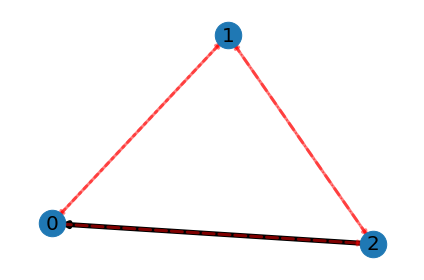

,verse_name,pivot_aye_pr,pivot_aye_a,pivot_aye_h
108,کوثر,إِنَّا أَعْطَيْنَاكَ الْكَوْثَرَ,إِنَّا أَعْطَيْنَاكَ الْكَوْثَرَ,فَصَلِّ لِرَبِّكَ وَ انْحَرْ


In [21]:
find_pivot_aye('کوثر', draw_graph=True)

<div dir="rtl">
در سوره‌ی حمد آیه‌ی محوری بر اساس pr و هم‌چنین پرامتیازترین نود a نیز آیه‌ی  بسم الله الرحمن الرحیم است. هم‌چنین پر امتیاز ترین نود هاب نیز الرحمن الرحیم است. سنگین ترین یال نیز مربوط به شباهت الرحمن الرحیم به بسم الله الرحمن الرحیم است.
<div>

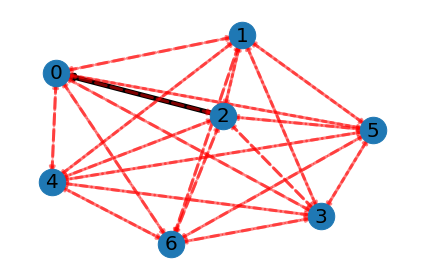

,verse_name,pivot_aye_pr,pivot_aye_a,pivot_aye_h
1,فاتحه,بِسْمِ اللَّهِ الرَّحْمَنِ الرَّحِيمِ,بِسْمِ اللَّهِ الرَّحْمَنِ الرَّحِيمِ,الرَّحْمَنِ الرَّحِيمِ


In [22]:
find_pivot_aye('فاتحه', draw_graph=True)

<div dir="rtl">
در سوره‌ی قدر نیز آیه‌ی انا انزلناه فی لیله القدر محوری انتخاب شده‌است که خیلی منطقی است.
<div>

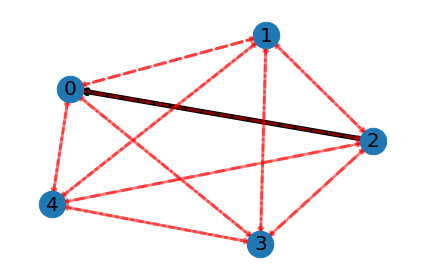

,verse_name,pivot_aye_pr,pivot_aye_a,pivot_aye_h
97,قدر,إِنَّا أَنْزَلْنَاهُ فِي لَيْلَةِ الْقَدْرِ,إِنَّا أَنْزَلْنَاهُ فِي لَيْلَةِ الْقَدْرِ,تَنَزَّلُ الْمَلَائِكَةُ وَ الرُّوحُ فِيهَا بِ...


In [23]:
find_pivot_aye('قدر', draw_graph=True)

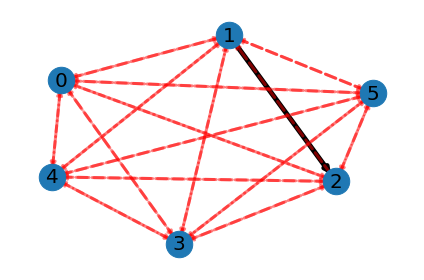

,verse_name,pivot_aye_pr,pivot_aye_a,pivot_aye_h
114,ناس,إِلَهِ النَّاسِ,إِلَهِ النَّاسِ,مِنْ شَرِّ الْوَسْوَاسِ الْخَنَّاسِ


In [24]:
find_pivot_aye('ناس' , draw_graph=True)

In [25]:
find_pivot_aye('کافرون')

,verse_name,pivot_aye_pr,pivot_aye_a,pivot_aye_h
109,کافرون,وَ لَا أَنْتُمْ عَابِدُونَ مَا أَعْبُدُ,وَ لَا أَنْتُمْ عَابِدُونَ مَا أَعْبُدُ,لَكُمْ دِينُكُمْ وَ لِيَ دِينِ


In [26]:
find_pivot_aye('فلق')

,verse_name,pivot_aye_pr,pivot_aye_a,pivot_aye_h
113,فلق,وَ مِنْ شَرِّ غَاسِقٍ إِذَا وَقَبَ,وَ مِنْ شَرِّ غَاسِقٍ إِذَا وَقَبَ,قُلْ أَعُوذُ بِرَبِّ الْفَلَقِ


In [27]:
find_pivot_aye('شمس')

,verse_name,pivot_aye_pr,pivot_aye_a,pivot_aye_h
91,شمس,فَأَلْهَمَهَا فُجُورَهَا وَ تَقْوَاهَا,فَأَلْهَمَهَا فُجُورَهَا وَ تَقْوَاهَا,وَ الشَّمْسِ وَ ضُحَاهَا


<div dir="rtl">
در بالا مثالهایی از سوره‌هایی از قران که ساده‌تر هستند، دیدیم. در زیر برای تمام سوره‌ها آیه‌ی محوری محاسبه شده‌است.
<div>

In [29]:
pivot_aye = pd.DataFrame()
for index, row in tqdm.tqdm(list(verse_names.iterrows())):
    pivot_aye = pd.concat([pivot_aye, find_pivot_aye(row['نام سوره'])])
pivot_aye

100%|██████████| 114/114 [00:08<00:00, 13.34it/s]


,verse_name,pivot_aye_pr,pivot_aye_a,pivot_aye_h
1,فاتحه,بِسْمِ اللَّهِ الرَّحْمَنِ الرَّحِيمِ,بِسْمِ اللَّهِ الرَّحْمَنِ الرَّحِيمِ,الرَّحْمَنِ الرَّحِيمِ
2,بقره,وَ إِذْ قَالَ إِبْرَاهِيمُ رَبِّ اجْعَلْ هَذَا...,وَ إِذْ قَالَ إِبْرَاهِيمُ رَبِّ اجْعَلْ هَذَا...,وَ قَاتِلُوا فِي سَبِيلِ اللَّهِ وَ اعْلَمُوا ...
3,آل عمران,وَ لَقَدْ صَدَقَكُمُ اللَّهُ وَعْدَهُ إِذْ تَح...,وَ لَقَدْ صَدَقَكُمُ اللَّهُ وَعْدَهُ إِذْ تَح...,يَا أَيُّهَا الَّذِينَ آمَنُوا إِنْ تُطِيعُوا ...
4,نساء,لَكِنِ الرَّاسِخُونَ فِي الْعِلْمِ مِنْهُمْ وَ...,لَكِنِ الرَّاسِخُونَ فِي الْعِلْمِ مِنْهُمْ وَ...,يَا أَيُّهَا الَّذِينَ آمَنُوا خُذُوا حِذْرَكُ...
5,مائده,وَ حَسِبُوا أَلَّا تَكُونَ فِتْنَةٌ فَعَمُوا و...,وَ حَسِبُوا أَلَّا تَكُونَ فِتْنَةٌ فَعَمُوا و...,أُحِلَّ لَكُمْ صَيْدُ الْبَحْرِ وَ طَعَامُهُ م...
...,...,...,...,...
110,نصر,وَ رَأَيْتَ النَّاسَ يَدْخُلُونَ فِي دِينِ الل...,وَ رَأَيْتَ النَّاسَ يَدْخُلُونَ فِي دِينِ الل...,إِذَا جَاءَ نَصْرُ اللَّهِ وَ الْفَتْحُ
111,مسد,وَ امْرَأَتُهُ حَمَّالَةَ الْحَطَبِ,وَ امْرَأَتُهُ حَمَّالَةَ الْحَطَبِ,مَا أَغْنَىٰ عَنْهُ مَالُهُ وَ مَا كَسَبَ
112,اخلاص,وَ لَمْ يَكُنْ لَهُ كُفُوًا أَحَدٌ,وَ لَمْ يَكُنْ لَهُ كُفُوًا أَحَدٌ,قُلْ هُوَ اللَّهُ أَحَدٌ
113,فلق,وَ مِنْ شَرِّ غَاسِقٍ إِذَا وَقَبَ,وَ مِنْ شَرِّ غَاسِقٍ إِذَا وَقَبَ,قُلْ أَعُوذُ بِرَبِّ الْفَلَقِ


In [30]:
print(pivot_aye['pivot_aye_a'].equals(pivot_aye['pivot_aye_h']))
print(pivot_aye['pivot_aye_a'].equals(pivot_aye['pivot_aye_pr']))

False
False


<div dir="rtl">
سوره‌هایی که در آن‌ها نتایج الگوریتم page rank با پرامتیاز ترین نود a متفاوت است را مشاهده می‌کنید. همانطور که مشخص است، تنها در ۶ سوره از قران این نتایج متفاوت هستند..
<div>

In [31]:
pivot_aye.loc[pivot_aye['pivot_aye_a'] != pivot_aye['pivot_aye_pr']]

,verse_name,pivot_aye_pr,pivot_aye_a,pivot_aye_h
32,سجدة,وَ لَوْ تَرَىٰ إِذِ الْمُجْرِمُونَ نَاكِسُو رُ...,أَ وَ لَمْ يَرَوْا أَنَّا نَسُوقُ الْمَاءَ إِل...,الم
81,تکویر,وَ إِذَا الْوُحُوشُ حُشِرَتْ,فَأَيْنَ تَذْهَبُونَ,وَ إِذَا الْجِبَالُ سُيِّرَتْ
99,زلزله,وَ مَنْ يَعْمَلْ مِثْقَالَ ذَرَّةٍ شَرًّا يَرَهُ,وَ أَخْرَجَتِ الْأَرْضُ أَثْقَالَهَا,بِأَنَّ رَبَّكَ أَوْحَىٰ لَهَا


<div dir="rtl">
در سوره‌ی الرحمن، هم خروجی pr و پر امتیازترین نود a با هم یکی هستند. هم تنها سوره‌ای است که در آن آیه‌ی محوری پرامتیاز ترین نود هاب نیز هست. آیه نیز کاملا آیه‌ی پرتکراری در این سوره است. اگر با سوره‌ی الرحمن آشنا باشید، متوجه می‌شوید این ایه چندین بار در طول سوره تکرار می‌شود.
<div>

In [32]:
pivot_aye.loc[pivot_aye['pivot_aye_a'] == pivot_aye['pivot_aye_h']]

,verse_name,pivot_aye_pr,pivot_aye_a,pivot_aye_h
55,الرحمن,فَبِأَيِّ آلَاءِ رَبِّكُمَا تُكَذِّبَانِ,فَبِأَيِّ آلَاءِ رَبِّكُمَا تُكَذِّبَانِ,فَبِأَيِّ آلَاءِ رَبِّكُمَا تُكَذِّبَانِ


In [33]:
pivot_aye.loc[pivot_aye['pivot_aye_h'] == pivot_aye['pivot_aye_pr']]

,verse_name,pivot_aye_pr,pivot_aye_a,pivot_aye_h
55,الرحمن,فَبِأَيِّ آلَاءِ رَبِّكُمَا تُكَذِّبَانِ,فَبِأَيِّ آلَاءِ رَبِّكُمَا تُكَذِّبَانِ,فَبِأَيِّ آلَاءِ رَبِّكُمَا تُكَذِّبَانِ


<div dir="rtl">
همانطور که در نتایج بالا مشخص بود، برای سوره‌هایی که دیدیم و کوتاه‌تر هستند و تسلط بیشتری بر آنان داشتیم، ایات معقول و درستی به عنوان آیات محوری خروجی داده شده بود. همچنین خروجی الگوریتم پیج رنک و هم‌چنین پرامتیاز ترین نود authority که درواقع نودی است که توسط هاب‌های خوبی به‌آن اشاره شده، تقریبا یکسان هستند.
<div>